# **Task 3: Pre-trained models: pointclouds**

In [ ]:
# necessary imports
import os
import glob
import numpy
import pandas
import random
import trimesh
import logging
import tensorflow
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras import models, layers, regularizers, optimizers, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input

# import Stratified K-Fold Cross Validation notebook
%run KFold-Cross-Validation.ipynb

# dataset root path
DATASET_ROOT = '/run/media/rr/M2/DevOps/jupyter-lab/CIDL/dataset/'

# final preprocessed dataset directory path
DATASET_PATH = os.path.join(DATASET_ROOT, 'Preprocessed')

# number of classes for the classification task
NUM_CLASSES = 5

In [ ]:
# only log critical messages
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## Input Target Size

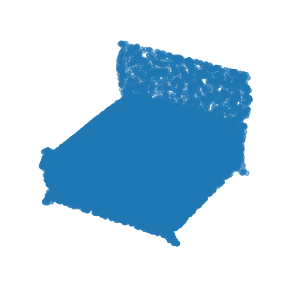

In [3]:
example_path = os.path.join(DATASET_PATH, 'Bed/pointclouds', '1a8e293609eca3b3f7e27638e63d848.obj')
example_obj_file = glob.glob(example_path)
example_mesh = trimesh.load(example_obj_file[0], force='mesh')
points = example_mesh.sample(16384)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
#plt.savefig('imgs/example-mesh-resolution-16384.jpg', dpi=200)
plt.show()

In [4]:
# target size
TARGET_SIZE = 16384

# **PointNet**

In [ ]:
def mat_mul(A, B):
    return tensorflow.matmul(A, B)

In [ ]:
# ------------------------------------ PointNet ------------------------------------
# input transform net
input_points = Input(shape=(TARGET_SIZE, 3))
x = Conv1D(64, 1, activation='relu', input_shape=(TARGET_SIZE, 3))(input_points)
x = BatchNormalization()(x)
x = Conv1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=TARGET_SIZE)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[numpy.zeros([256, 9]), numpy.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(numpy.float32)])(x)
input_T = tensorflow.reshape(x, (3, 3))

# feature extraction
#g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Conv1D(64, 1, input_shape=(TARGET_SIZE, 3), activation='relu')(input_points)
g = BatchNormalization()(g)
g = Conv1D(64, 1, input_shape=(TARGET_SIZE, 3), activation='relu')(g)
g = BatchNormalization()(g)

# feature transform net
f = Conv1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Conv1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Conv1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=TARGET_SIZE)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[numpy.zeros([256, 64 * 64]), numpy.eye(64).flatten().astype(numpy.float32)])(f)
feature_T = tensorflow.reshape(f, (64, 64))

# feature extraction
#g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Conv1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Conv1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Conv1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

# global feature
global_feature = MaxPooling1D(pool_size=TARGET_SIZE)(g)

# pointnet classifier
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(NUM_CLASSES, activation='softmax')(c)
prediction = Flatten()(c)
# ------------------------------------ PointNet ------------------------------------

model = Model(inputs=input_points, outputs=prediction)

# train, validate and test
pointclouds_kfold_validation_model(model_name="PointNet", n_splits=6, test_size=0.05,
                        shuffle=True, model=model, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=100,
                        batch_size=32, one_fold=True, resample_data=0, augment=False)